In [1]:
# modules
import numpy as np
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

In [2]:
# my score function
def myscore(y,yhat_prob,min_r=0.95,th_f=None):
    p,r,th = precision_recall_curve(y,yhat_prob[:,1])
    if th_f == None:
        th_f = np.concatenate(([0],th))[r>min_r].max()
    yhat = (yhat_prob[:,1]>th_f)+1-1
    ct = pd.crosstab(yhat,y).values
    if ct.shape[0] == 1:
        m = np.array([0,0,ct[0][0],ct[0][1]])
    else:
        m = ct.reshape((4,))
    acc = (m[0]+m[3])/m.sum()
    precision = m[3]/(m[2]+m[3])
    recall = m[3]/(m[1]+m[3])
    return acc, precision, recall, m[0], m[1], m[2], m[3], th_f

In [3]:
# read training data
df_train = pd.read_csv('data_semi_train_clean.csv')
xtrain_df = df_train.iloc[:,1:]
xtrain = xtrain_df.values
ytrain = (df_train['Label']=='defect').values+1-1

In [4]:
df_test = pd.read_csv('data_semi_test.csv')
xtest_df = df_test.iloc[:,1:]
xtest = xtest_df.values
ytest = (df_test['Label']=='defect').values+1-1

In [5]:
xtest.shape

(5746, 590)

In [6]:
ytest.shape

(5746,)

In [9]:
# feature selection
col = xtrain_df.columns
xtest_df = xtest_df[col]
xtest = xtest_df.values

In [10]:
# missing imputation
from sklearn.impute import SimpleImputer
model_imp = SimpleImputer(strategy='median')
model_imp.fit(xtrain)
xtest = model_imp.transform(xtest)

In [11]:
# outlier handling
for i in range(xtrain.shape[1]):
    x = xtrain[:,i]
    m = x.mean()
    s = np.sqrt(x.var(ddof=1))
    uidx = x>m+6*s
    lidx = x<m-6*s
    usub = x[~uidx & ~lidx].max()
    lsub = x[~uidx & ~lidx].min()

    x = xtest[:,i]
    uidx = x>m+6*s
    lidx = x<m-6*s    
    x[uidx] = usub
    x[lidx] = lsub
    xtest[:,i] = x

In [12]:
############################################################
# normalization
############################################################

from sklearn.preprocessing import StandardScaler
model_scale = StandardScaler()
model_scale.fit(xtrain)
xtrain = model_scale.transform(xtrain)
xtest = model_scale.transform(xtest)

In [13]:
############################################################
# final model
############################################################

X = xtrain.copy()
Y = ytrain.copy()
xtrain, xval, ytrain, yval = train_test_split(X,Y,test_size=0.2,random_state=0)

In [14]:
from sklearn.svm import SVC
f = SVC(C=10,probability=True)
f.fit(xtrain,ytrain)

yhat_train_prob = f.predict_proba(xtrain)
yhat_val_prob = f.predict_proba(xval)
yhat_test_prob = f.predict_proba(xtest)

myscore(yval,yhat_val_prob,min_r=0.99)

myscore(ytrain,yhat_train_prob,th_f=0.03)
myscore(yval,yhat_val_prob,th_f=0.03)
myscore(ytest,yhat_test_prob,th_f=0.03)

(0.9878176122520014,
 0.8568376068376068,
 0.9925742574257426,
 5275,
 3,
 67,
 401,
 0.03)

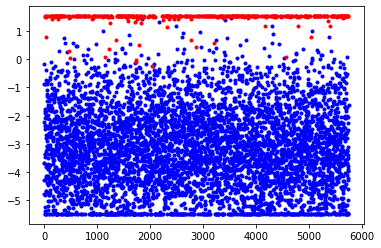

In [15]:
# visualization
i = np.arange(len(ytest))
nidx = ytest==0
didx = ytest==1
p = np.log10(yhat_test_prob[:,1]/0.03)
plt.plot(i[nidx],p[nidx],'b.',i[didx],p[didx],'r.')